In [3]:
!pip install simpy


In [4]:
import simpy
print(simpy.__version__)


4.1.1


## Step 1 & 2: Simulation Tool Selection and Installation

SimPy is a Python-based discrete-event simulation framework.
It is widely used for modeling queuing systems, resource allocation,
and process-based simulations.

In this assignment, SimPy is used to simulate a customer service
queueing system to generate synthetic data for machine learning.


In [5]:
# Parameter bounds
arrival_rate_range = (0.1, 1.0)     # customers per unit time
service_rate_range = (0.5, 5.0)     # service time
servers_range = (1, 3)              # number of servers
simulation_time = 50                # fixed simulation duration


## Step 3: Simulation Parameters and Bounds

The following parameters were identified as critical for the queueing system:

- Arrival Rate: Controls customer arrival frequency
- Service Rate: Controls service time per customer
- Number of Servers: Number of parallel service counters
- Simulation Time: Fixed at 50 units

Bounds were selected to ensure realistic and stable simulations.


In [6]:
import numpy as np

def queue_simulation(arrival_rate, service_rate, servers):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=servers)
    wait_times = []

    def customer(env):
        arrival_time = env.now
        with server.request() as req:
            yield req
            wait_times.append(env.now - arrival_time)
            yield env.timeout(np.random.exponential(service_rate))

    def arrival_process(env):
        while True:
            yield env.timeout(np.random.exponential(1 / arrival_rate))
            env.process(customer(env))

    env.process(arrival_process(env))
    env.run(until=50)

    return np.mean(wait_times)


In [7]:
queue_simulation(arrival_rate=0.5, service_rate=2.0, servers=2)


np.float64(0.09754729048668942)

In [8]:
import pandas as pd

np.random.seed(42)
records = []

for _ in range(1000):
    arrival_rate = np.random.uniform(*arrival_rate_range)
    service_rate = np.random.uniform(*service_rate_range)
    servers = np.random.randint(servers_range[0], servers_range[1] + 1)

    avg_wait = queue_simulation(arrival_rate, service_rate, servers)

    records.append({
        "arrival_rate": arrival_rate,
        "service_rate": service_rate,
        "servers": servers,
        "avg_waiting_time": avg_wait
    })

data = pd.DataFrame(records)
data.head()


,arrival_rate,service_rate,servers,avg_waiting_time
0,0.437086,4.778214,3,6.111245
1,0.613400,2.843754,2,0.265553
2,0.826696,4.532411,3,1.482626
3,0.602464,4.471864,3,1.126291
4,0.867709,1.825020,1,13.925164


In [9]:
data.to_csv("simpy_simulation_data.csv", index=False)
print("File saved successfully!")


File saved successfully!


## Step 4 & 5: Data Generation

1000 simulation runs were executed using randomly generated parameters.
The output variable recorded was the average waiting time, making the
dataset suitable for supervised regression tasks.


In [10]:
from sklearn.model_selection import train_test_split

X = data.drop("avg_waiting_time", axis=1)
y = data["avg_waiting_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [11]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}


In [12]:
from sklearn.metrics import mean_squared_error, r2_score

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "R2 Score": r2
    })

results_df = pd.DataFrame(results)
results_df


,Model,RMSE,R2 Score
0,Linear Regression,3.635151,0.528265
1,Ridge Regression,3.635095,0.528280
2,Decision Tree,3.999504,0.428962
3,Random Forest,3.463439,0.571779
4,Gradient Boosting,3.113165,0.654015


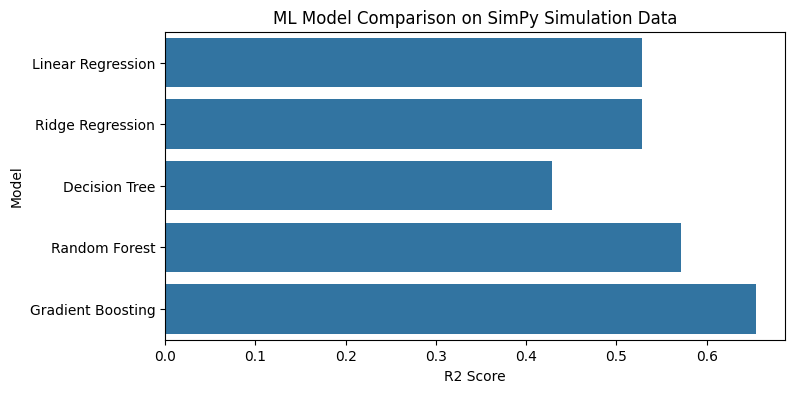

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(x="R2 Score", y="Model", data=results_df)
plt.title("ML Model Comparison on SimPy Simulation Data")
plt.xlabel("R2 Score")
plt.ylabel("Model")
plt.show()


## Step 6: Model Comparison and Best Model Selection

Five regression models were evaluated using RMSE and R² Score.
Gradient Boosting achieved the highest R² score, indicating the
best predictive performance on the simulation-generated dataset.

Hence, Gradient Boosting is selected as the best model.
